# Model Result Analysis
This notebook will be used to collect and do some brief analysis of the results of the models.

### Models ( in order of creation ):

- naive_bayes
- naive_bayes_ngram
- naive_bayes_Word2Vec
- SVM
- LSTM
- BERT


### The models will be evaluated on the following metrics:
- Accuracy
- Precision
- Recall
- F1 Score
- ROC AUC Score
- Time taken to train the model
- Time taken to predict the test data

### I will also compare the results of using the random substrings with random_substrings per input at:
- 5
- 10
- 50

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import makedirs

# Make analysis directory
makedirs('analysis', exist_ok=True)

In [2]:
# Configure Seaborn
sns.set_theme(style='dark')
# disable top and right spines
sns.despine()

<Figure size 640x480 with 0 Axes>

In [3]:
model_names = [
    'naive_bayes',
    'naive_bayes_ngram',
    'naive_bayes_Word2Vec',
    'SVM',
    'LSTM',
    'BERT'
]

random_substring_n = [5, 10, 50]

# Model results are stored in
# 'models/results/{model_name}.csv'
# 'models/results/{model_name}_metadata.txt'

# Random substring results are stored with model_name = {model_name}__random_{n}

predictions_schema = {
    'text': str,
    'label': int,
    'prediction': int,
    'prediction_proba': float
}

# Load model results
model_results = {}
for model_name in model_names:
    model_results[model_name] = pd.read_csv(f'models/results/{model_name}.csv', dtype=predictions_schema)
    for n in random_substring_n:
        # Not all models have random substring results
        try:
            model_results[f'{model_name}__random_{n}'] = pd.read_csv(f'models/results/{model_name}__random_{n}.csv', dtype=predictions_schema)
        except FileNotFoundError:
            pass

# Load model metadata
# Meta data looks like:
"""Timings
...
fit:start: 874.310172643
fit:end: 2505.80812131
predict:start: 2505.80815885
predict:end: 2547.216579963
...
"""

# We are interested in the time taken to fit and predict
model_metadata = {}
def extract_model_time(model_name):
    fit_start, fit_end, predict_start, predict_end = None, None, None, None

    with open(f'models/results/{model_name}_metadata.txt', 'r') as f:
        for line in f.readlines():
            if line.startswith('fit:start'):
                fit_start = float(line.split(':')[-1].strip())
            elif line.startswith('fit:end'):
                fit_end = float(line.split(':')[-1].strip())
            elif line.startswith('predict:start'):
                predict_start = float(line.split(':')[-1].strip())
            elif line.startswith('predict:end'):
                predict_end = float(line.split(':')[-1].strip())

    fit_time = fit_end - fit_start
    predict_time = predict_end - predict_start

    return fit_time, predict_time

for model_name in model_names:

    fit_time, predict_time = extract_model_time(model_name)

    model_metadata[model_name] = {
        'fit_time': fit_time,
        'predict_time': predict_time
    }

    for n in random_substring_n:
        try:
            fit_time, predict_time = extract_model_time(f'{model_name}__random_{n}')

            model_metadata[f'{model_name}__random_{n}'] = {
                'fit_time': fit_time,
                'predict_time': predict_time
            }
        except FileNotFoundError:
            pass


In [4]:
# Convert model metadata to DataFrame
model_metadata_df = pd.DataFrame(model_metadata).T

# Add "model" column
model_metadata_df.reset_index(names='model', inplace=True)

# Add "base_model" column
model_metadata_df['base_model'] = model_metadata_df['model'].str.split('__').str[0]

# Add "random substring" column
model_metadata_df['random_substring'] = model_metadata_df['model'].str.contains('random')
model_metadata_df['substring_count'] = 0
sub_string_count = model_metadata_df.loc[model_metadata_df['random_substring'], 'model' ].str.extract(r'random_(\d+)').astype(int)
sub_string_count = sub_string_count.values
model_metadata_df.loc[model_metadata_df['random_substring'], 'substring_count'] = sub_string_count

# Order columns
model_metadata_df = model_metadata_df[['model', 'base_model', 'random_substring', 'substring_count', 'fit_time', 'predict_time']]

model_metadata_df

,model,base_model,random_substring,substring_count,fit_time,predict_time
0,naive_bayes,naive_bayes,False,0,0.735466,0.097164
1,naive_bayes__random_5,naive_bayes,True,5,1.527213,0.100070
2,naive_bayes__random_10,naive_bayes,True,10,2.136096,0.092963
3,naive_bayes__random_50,naive_bayes,True,50,7.616891,0.094021
4,naive_bayes_ngram,naive_bayes_ngram,False,0,6.222149,0.333206
5,naive_bayes_ngram__random_5,naive_bayes_ngram,True,5,8.888904,0.335436
6,naive_bayes_ngram__random_10,naive_bayes_ngram,True,10,11.229218,0.340284
7,naive_bayes_ngram__random_50,naive_bayes_ngram,True,50,29.717797,0.376402
8,naive_bayes_Word2Vec,naive_bayes_Word2Vec,False,0,7.259088,0.340783
9,naive_bayes_Word2Vec__random_5,naive_bayes_Word2Vec,True,5,14.438580,0.340986


In [5]:
# Calculate metrics for each model
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, log_loss, auc

def calculate_metrics(df: pd.DataFrame):
    metrics = {}
    classification_report_df = classification_report(df['label'], df['prediction'], output_dict=True)
    metrics['accuracy'] = classification_report_df['accuracy']
    metrics['precision'] = classification_report_df['macro avg']['precision']
    metrics['recall'] = classification_report_df['macro avg']['recall']
    metrics['f1'] = classification_report_df['macro avg']['f1-score']
    metrics['roc_auc'] = roc_auc_score(df['label'], df['prediction_proba'])

    # Confusion Matrix
    tn, fp, fn, tp = confusion_matrix(df['label'], df['prediction']).ravel()
    metrics['specificity'] = tn / (tn + fp)
    metrics['sensitivity'] = tp / (tp + fn)
    
    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(df['label'], df['prediction_proba'])
    metrics['pr_auc'] = auc(recall, precision)
    
    
    # Log Loss
    metrics['log_loss'] = log_loss(df['label'], df['prediction_proba'])

    return metrics

model_metrics = {}
for model_name, results_df in model_results.items():
    model_metrics[model_name] = calculate_metrics(results_df)

model_metrics_df = pd.DataFrame(model_metrics).T
model_metrics_df.reset_index(inplace=True, names='model')
model_metrics_df

model_metrics_df = model_metadata_df.merge(model_metrics_df, on='model')
model_metrics_df

,model,base_model,random_substring,substring_count,fit_time,predict_time,accuracy,precision,recall,f1,roc_auc,specificity,sensitivity,pr_auc,log_loss
0,naive_bayes,naive_bayes,False,0,0.735466,0.097164,0.979778,0.981735,0.975565,0.978473,0.998224,0.993573,0.957557,0.997453,0.138541
1,naive_bayes__random_5,naive_bayes,True,5,1.527213,0.100070,0.981364,0.980195,0.980383,0.980289,0.998323,0.984576,0.976190,0.997518,0.096834
2,naive_bayes__random_10,naive_bayes,True,10,2.136096,0.092963,0.981761,0.980003,0.981490,0.980735,0.998379,0.982648,0.980331,0.997571,0.086791
3,naive_bayes__random_50,naive_bayes,True,50,7.616891,0.094021,0.983347,0.981339,0.983560,0.982423,0.998083,0.982648,0.984472,0.997229,0.070845
4,naive_bayes_ngram,naive_bayes_ngram,False,0,6.222149,0.333206,0.957573,0.966575,0.945402,0.954151,0.997853,0.997429,0.893375,0.996712,0.193881
5,naive_bayes_ngram__random_5,naive_bayes_ngram,True,5,8.888904,0.335436,0.978985,0.981570,0.974137,0.977600,0.998285,0.994859,0.953416,0.997389,0.099031
6,naive_bayes_ngram__random_10,naive_bayes_ngram,True,10,11.229218,0.340284,0.980571,0.981707,0.977189,0.979351,0.998349,0.991645,0.962733,0.997486,0.078444
7,naive_bayes_ngram__random_50,naive_bayes_ngram,True,50,29.717797,0.376402,0.980174,0.977522,0.980793,0.979099,0.998314,0.978149,0.983437,0.997432,0.060622
8,naive_bayes_Word2Vec,naive_bayes_Word2Vec,False,0,7.259088,0.340783,0.920301,0.916157,0.915000,0.915570,0.966048,0.937661,0.892340,0.948657,1.335186
9,naive_bayes_Word2Vec__random_5,naive_bayes_Word2Vec,True,5,14.438580,0.340986,0.937351,0.930729,0.939023,0.934388,0.978898,0.931877,0.946170,0.967657,0.572906


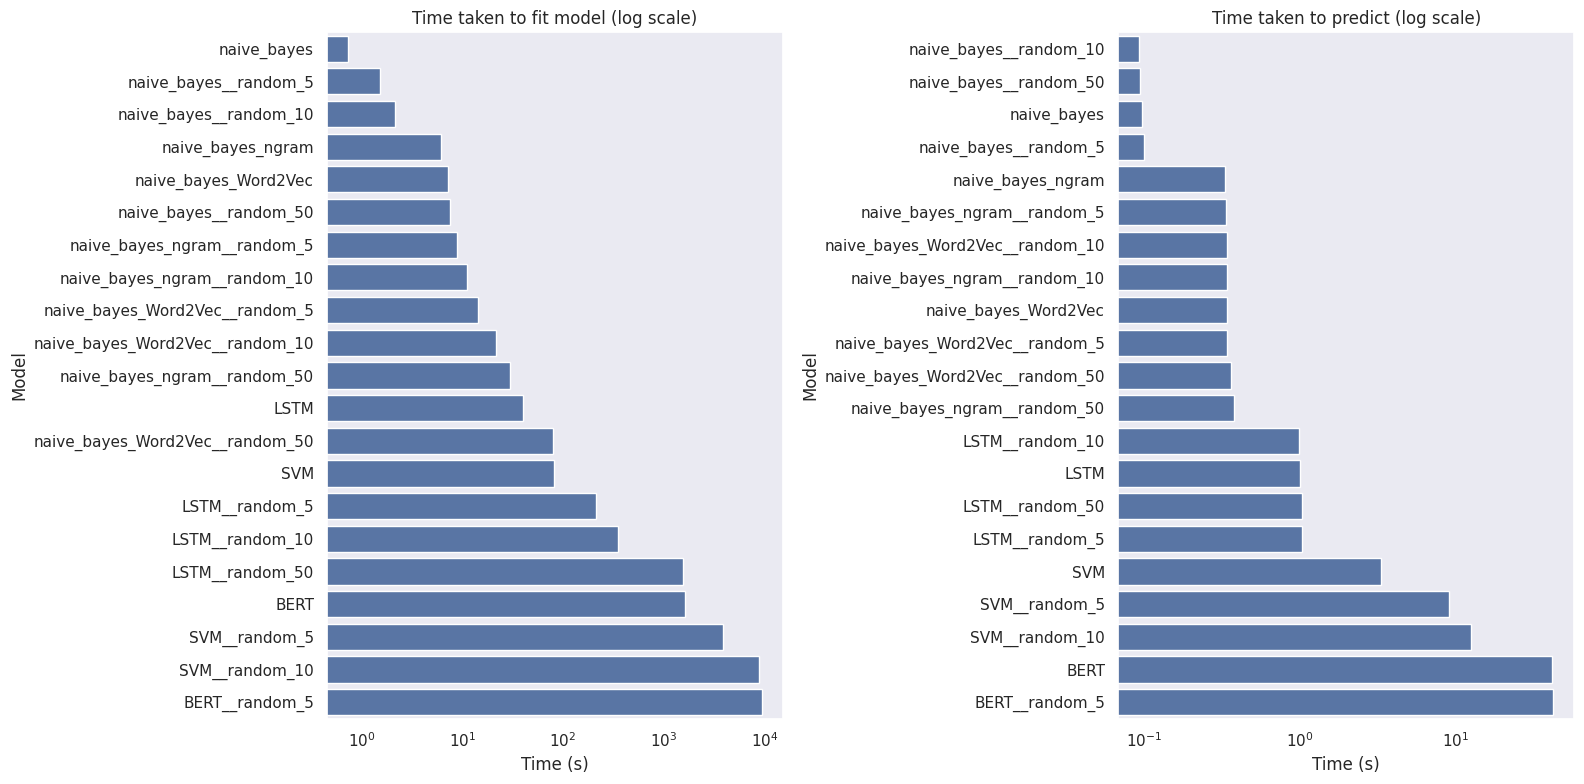

In [6]:
# Sort the DataFrame by fit_time and predict_time in ascending order
model_metadata_df_sorted = model_metadata_df.sort_values(['fit_time'], ascending=True)

# Create a log plot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x='fit_time', y='model', data=model_metadata_df_sorted, ax=ax[0])
ax[0].set_title('Time taken to fit model (log scale)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Model')
ax[0].set_xscale('log')


model_metadata_df_sorted = model_metadata_df.sort_values(['predict_time'], ascending=True)

sns.barplot(x='predict_time', y='model', data=model_metadata_df_sorted, ax=ax[1])
ax[1].set_title('Time taken to predict (log scale)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Model')
ax[1].set_xscale('log')

plt.tight_layout()

plt.savefig('analysis/model_time.png', dpi=2**8)

plt.show()

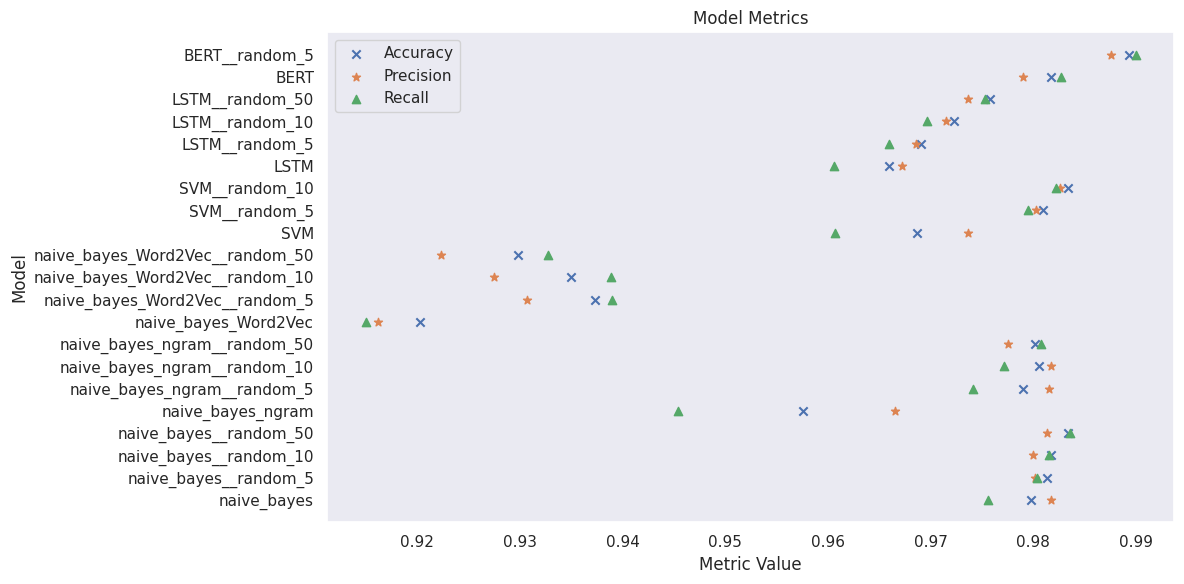

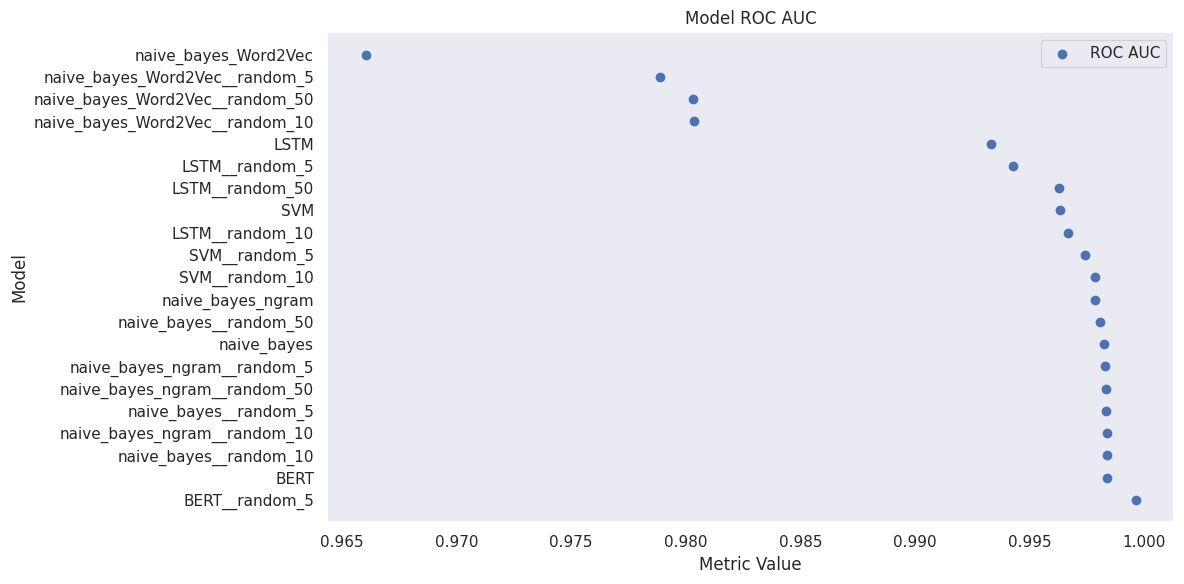

In [7]:
# plot accuracy, precision, recall, f1, roc_auc
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for accuracy
ax.scatter(model_metrics_df['accuracy'], model_metrics_df['model'], label='Accuracy', marker='x')

# Scatter plot for precision
ax.scatter(model_metrics_df['precision'], model_metrics_df['model'], label='Precision', marker='*')

# Scatter plot for recall
ax.scatter(model_metrics_df['recall'], model_metrics_df['model'], label='Recall', marker='^')

ax.set_title('Model Metrics')
ax.set_xlabel('Metric Value')
ax.set_ylabel('Model')
ax.legend()

plt.tight_layout()
plt.savefig('analysis/model_metrics.png', dpi=2**8)
plt.show()

# plot accuracy, precision, recall, f1, roc_auc
fig, ax = plt.subplots(figsize=(12, 6))

model_metrics_df.sort_values('roc_auc', ascending=False, inplace=True)

# Scatter plot for roc_auc
ax.scatter(model_metrics_df['roc_auc'], model_metrics_df['model'], label='ROC AUC', marker='o')

ax.set_title('Model ROC AUC')
ax.set_xlabel('Metric Value')
ax.set_ylabel('Model')
ax.legend()

plt.tight_layout()
plt.savefig('analysis/model_roc_auc.png', dpi=2**8)
plt.show()

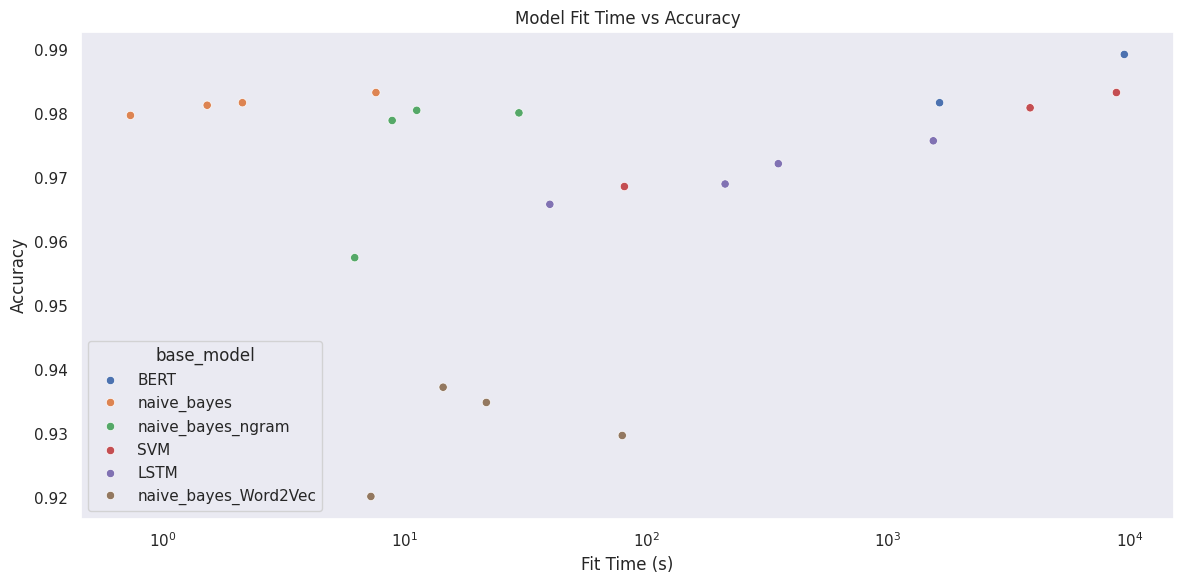

In [8]:
# Plot training time vs accuracy
fig, ax = plt.subplots(figsize=(12, 6))

sns.scatterplot(x='fit_time', y='accuracy', hue='base_model', data=model_metrics_df, ax=ax)

ax.set_xscale('log')

ax.set_title('Model Fit Time vs Accuracy')
ax.set_xlabel('Fit Time (s)')
ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('analysis/model_fit_time_vs_accuracy.png', dpi=2**8)
plt.show()

In [9]:
# Limit and pivot the DataFrame to compare effect of random substring
limited_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Rename 'base_model' to 'Model'
model_metrics_df.rename(columns={'base_model': 'Model'}, inplace=True)

for metric in limited_metrics:
    model_metrics_df_limited = model_metrics_df[['Model', 'substring_count', metric]]
    model_metrics_df_limited_pivot = model_metrics_df_limited.pivot(index='Model', columns='substring_count', values=metric)

    # Combine columns into a single column
    # model_metrics_df_limited_pivot.columns = model_metrics_df_limited_pivot.columns.map('{0[0]} ({0[1]})'.format)
    # Set value to str.title
    # model_metrics_df_limited_pivot.columns = model_metrics_df_limited_pivot.columns.str.title()

    # Make the highest value in each column bold
    def bold_max(s):
        is_max = s == s.max()
        return ['**{:.4f}**'.format(v) if is_max else '{:.4f}'.format(v) for v, is_max in zip(s, is_max)]

    model_metrics_df_limited_pivot = model_metrics_df_limited_pivot.apply(bold_max, axis=0)

    md_table = model_metrics_df_limited_pivot.to_markdown(tablefmt='github')

    with open(f'analysis/model_{metric}.md', 'w') as f:
        f.write(f'## {metric.title()}\n')
        f.write(md_table)

## Failure analysis
Because we used the same seed for all the models, we can compare the results of the models to see if there are any patterns in the misclassifications.

In [10]:
# From model_results, join together all the predictions text
# for each model

# Join all the predictions
all_predictions = pd.concat(model_results.values(), ignore_index=True)

# Group by text and get the mean prediction probability, positive count and negative count
all_predictions['correct'] = (all_predictions['label'] == all_predictions['prediction']).astype(int)

all_predictions_grouped = all_predictions.groupby('text').agg({
    'prediction_proba': 'mean',
    'correct': 'sum',
    'label': 'max'
}).reset_index()

all_predictions_grouped

,text,prediction_proba,correct,label
0,' -- change lobsters and retire in same order ...,0.017139,21,0
1,'a fine day your majesty ' the duchess began i...,0.012072,21,0
2,'all right so far ' said the king and he went ...,0.102122,19,0
3,'and be quick about it ' added the hatter 'or ...,0.026241,21,0
4,'and how did you manage on the twelfth ' alice...,0.043153,21,0
...,...,...,...,...
2516,your feelings are singular they seem to satisf...,0.656986,15,1
2517,your offer he said is far too idiotic to be de...,0.019346,21,0
2518,your river mist he said has a rum smell,0.010980,21,0
2519,your secret asked the staring gregory have you...,0.008783,21,0


## True Positives

In [22]:
# Get the Top 10 most confident correct predictions for label 1
top_5 = all_predictions_grouped.loc[(all_predictions_grouped['label'] == 1) & (all_predictions_grouped['correct'] > 0)].nlargest(5, 'prediction_proba')
top_5

# Limit text length to 400 characters, if longer end with ...(x more characters)
top_5['text_length'] = top_5['text'].str.len()
top_5['text'] = top_5['text'].str.slice(0, 400)
top_5['text'] = top_5['text'] + top_5['text_length'].apply(lambda x: f'...({x-400} more characters)' if x > 400 else '')

top_5.drop(columns='text_length', inplace=True)

# Save as markdown
with open('analysis/top_5_true_positives.md', 'w') as f:
    f.write('## Top 5 True Positives\n')
    f.write(top_5.to_markdown(tablefmt='github'))

## True Negatives

In [23]:
# Get the Top 10 most confident correct predictions for label 0
top_5 = all_predictions_grouped.loc[(all_predictions_grouped['label'] == 0) & (all_predictions_grouped['correct'] > 0)].nsmallest(5, 'prediction_proba')
print(top_5.iloc[0]['text'])
top_5

# Limit text length to 400 characters, if longer end with ...(x more characters)
top_5['text_length'] = top_5['text'].str.len()
top_5['text'] = top_5['text'].str.slice(0, 400)
top_5['text'] = top_5['text'] + top_5['text_length'].apply(lambda x: f'...({x-400} more characters)' if x > 400 else '')

top_5.drop(columns='text_length', inplace=True)
# Save as markdown
with open('analysis/top_5_true_negatives.md', 'w') as f:
    f.write('## Top 5 True Negatives\n')
    f.write(top_5.to_markdown(tablefmt='github'))

by the city's quadrangular houses -- in log huts camping with lumber-men along the ruts of the turnpike along the dry gulch and rivulet bed weeding my onion-patch or hosing rows of carrots and parsnips crossing savannas trailing in forests prospecting gold-digging girdling the trees of a new purchase scorch'd ankle-deep by the hot sand hauling my boat down the shallow river where the panther walks to and fro on a limb overhead where the buck turns furiously at the hunter where the rattlesnake suns his flabby length on a rock where the otter is feeding on fish where the alligator in his tough pimples sleeps by the bayou where the black bear is searching for roots or honey where the beaver pats the mud with his paddle-shaped tall over the growing sugar over the yellow-flower'd cotton plant over the rice in its low moist field over the sharp-peak'd farm house with its scallop'd scum and slender shoots from the gutters over the western persimmon over the long-leav'd corn over the delicate 

## False Positives

In [24]:
# Get the Top 10 most confident incorrect predictions for label 0
top_5 = all_predictions_grouped.loc[(all_predictions_grouped['label'] == 0)].sort_values(['correct', 'prediction_proba'], ascending=[True, False]).head(5)
print(top_5.iloc[0]['text'])
top_5

# Limit text length to 400 characters, if longer end with ...(x more characters)
top_5['text_length'] = top_5['text'].str.len()
top_5['text'] = top_5['text'].str.slice(0, 400)
top_5['text'] = top_5['text'] + top_5['text_length'].apply(lambda x: f'...({x-400} more characters)' if x > 400 else '')

top_5.drop(columns='text_length', inplace=True)
# Save as markdown
with open('analysis/top_5_false_positives.md', 'w') as f:
    f.write('## Top 5 False Positives\n')
    f.write(top_5.to_markdown(tablefmt='github'))

6 what will be will be well for what is is well to take interest is well and not to take interest shall be well


# False Negatives

In [14]:
# Get the Top 10 most confident incorrect predictions for label 1
top_5 = all_predictions_grouped.loc[(all_predictions_grouped['label'] == 1)].sort_values(['correct', 'prediction_proba'], ascending=[True, True]).head(5)
print(top_5.iloc[0]['text'])
top_5

# Limit text length to 400 characters, if longer end with ...(x more characters)
top_5['text_length'] = top_5['text'].str.len()
top_5['text'] = top_5['text'].str.slice(0, 400)
top_5['text'] = top_5['text'] + top_5['text_length'].apply(lambda x: f'...({x-400} more characters)' if x > 400 else '')

top_5.drop(columns='text_length', inplace=True)
# Save as markdown
with open('analysis/top_5_false_negatives.md', 'w') as f:
    f.write('## Top 5 False Negatives\n')
    f.write(top_5.to_markdown(tablefmt='github'))

at this point in the first and second editions volume 1 ends


# K fold quick analysis
I will also do a quick analysis of the naive bayes model using k fold cross validation

In [15]:
# Model results are stored in
# 'models/results/naive_bayes_kfolds/naive_bayes_fold_{fold}.csv'

# Load model results
model_results_kfolds = {}
model_name = 'naive_bayes'
model_results_kfolds[model_name] = []
for fold in range(5):
    model_results_kfolds[model_name].append(pd.read_csv(f'models/results/{model_name}_kfolds/{model_name}_fold_{fold}.csv', dtype=predictions_schema))

# Calculate metrics for each model
model_metrics_kfolds = {}
for model_name, results_df in model_results_kfolds.items():
    model_metrics_kfolds[model_name] = []
    for fold in range(5):
        metrics = calculate_metrics(results_df[fold])
        metrics_df = pd.DataFrame(metrics, index=[0])
        metrics_df['fold'] = fold
        metrics_df['model'] = model_name
        model_metrics_kfolds[model_name].append(metrics_df)

model_metrics_kfolds_df = pd.concat([df for df in model_metrics_kfolds['naive_bayes']])
model_metrics_kfolds_df

,accuracy,precision,recall,f1,roc_auc,specificity,sensitivity,pr_auc,log_loss,fold,model
0,0.980174,0.980724,0.977016,0.978810,0.997545,0.989822,0.964211,0.996157,0.140352,0,naive_bayes
0,0.982554,0.983060,0.979758,0.981361,0.998440,0.991094,0.968421,0.997674,0.136726,1,naive_bayes
0,0.978192,0.981022,0.972719,0.976583,0.998061,0.994911,0.950526,0.997200,0.132117,2,naive_bayes
0,0.975813,0.977260,0.971227,0.974086,0.996745,0.989822,0.952632,0.995579,0.141672,3,naive_bayes
0,0.982950,0.983592,0.980062,0.981773,0.998607,0.991736,0.968388,0.997951,0.135510,4,naive_bayes


/tmp/ipykernel_81464/1000058014.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


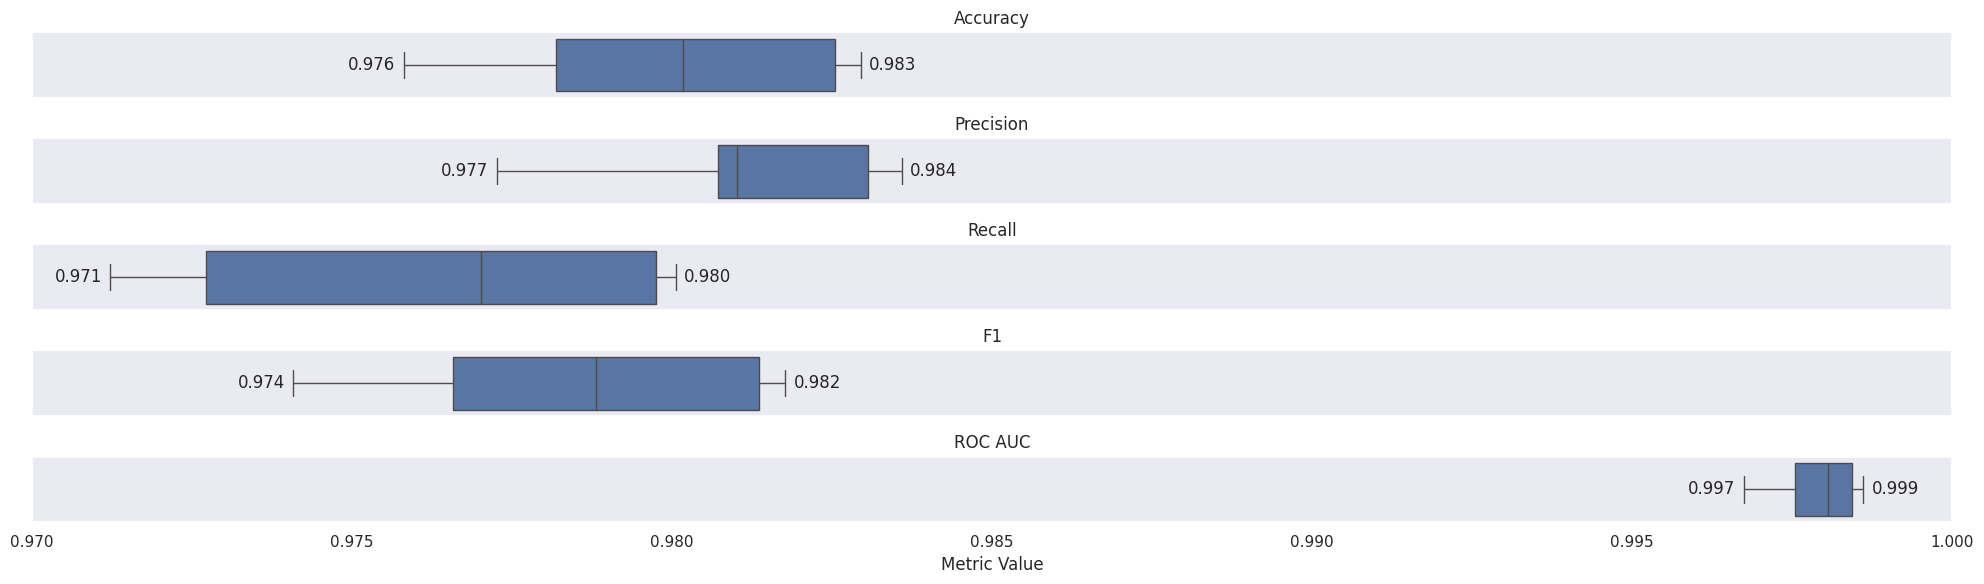

In [16]:
# Plot the spread of metrics across folds
fig, ax = plt.subplots(5, 1, figsize=(20, 6), sharex=True)

# Ax 1 - Accuracy
sns.boxplot(x='accuracy', data=model_metrics_kfolds_df, ax=ax[0])
ax[0].set_title('Accuracy')

min_accuracy = model_metrics_kfolds_df['accuracy'].min()
max_accuracy = model_metrics_kfolds_df['accuracy'].max()
# Add a label for the minimum and maximum accuracy
ax[0].text(min_accuracy-0.0005, 0, f'{min_accuracy:.3f}', ha='center', va='center')
ax[0].text(max_accuracy+0.0005, 0, f'{max_accuracy:.3f}', ha='center', va='center')

# Ax 2 - Precision
sns.boxplot(x='precision', data=model_metrics_kfolds_df, ax=ax[1])
ax[1].set_title('Precision')

min_precision = model_metrics_kfolds_df['precision'].min()
max_precision = model_metrics_kfolds_df['precision'].max()
# Add a label for the minimum and maximum precision
ax[1].text(min_precision-0.0005, 0, f'{min_precision:.3f}', ha='center', va='center')
ax[1].text(max_precision+0.0005, 0, f'{max_precision:.3f}', ha='center', va='center')

# Ax 3 - Recall
sns.boxplot(x='recall', data=model_metrics_kfolds_df, ax=ax[2])
ax[2].set_title('Recall')

min_recall = model_metrics_kfolds_df['recall'].min()
max_recall = model_metrics_kfolds_df['recall'].max()
# Add a label for the minimum and maximum recall
ax[2].text(min_recall-0.0005, 0, f'{min_recall:.3f}', ha='center', va='center')
ax[2].text(max_recall+0.0005, 0, f'{max_recall:.3f}', ha='center', va='center')

# Ax 4 - F1
sns.boxplot(x='f1', data=model_metrics_kfolds_df, ax=ax[3])
ax[3].set_title('F1')

min_f1 = model_metrics_kfolds_df['f1'].min()
max_f1 = model_metrics_kfolds_df['f1'].max()
# Add a label for the minimum and maximum f1
ax[3].text(min_f1-0.0005, 0, f'{min_f1:.3f}', ha='center', va='center')
ax[3].text(max_f1+0.0005, 0, f'{max_f1:.3f}', ha='center', va='center')

# Ax 5 - ROC AUC
sns.boxplot(x='roc_auc', data=model_metrics_kfolds_df, ax=ax[4])
ax[4].set_title('ROC AUC')

min_roc_auc = model_metrics_kfolds_df['roc_auc'].min()
max_roc_auc = model_metrics_kfolds_df['roc_auc'].max()
# Add a label for the minimum and maximum roc_auc
ax[4].text(min_roc_auc-0.0005, 0, f'{min_roc_auc:.3f}', ha='center', va='center')
ax[4].text(max_roc_auc+0.0005, 0, f'{max_roc_auc:.3f}', ha='center', va='center')

plt.xlabel('Metric Value')
plt.xlim(0.97, 1.0)

plt.tight_layout()
fig.savefig('analysis/model_metrics_kfolds.png', dpi=2**8)
fig.show()



/tmp/ipykernel_81464/3413563546.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


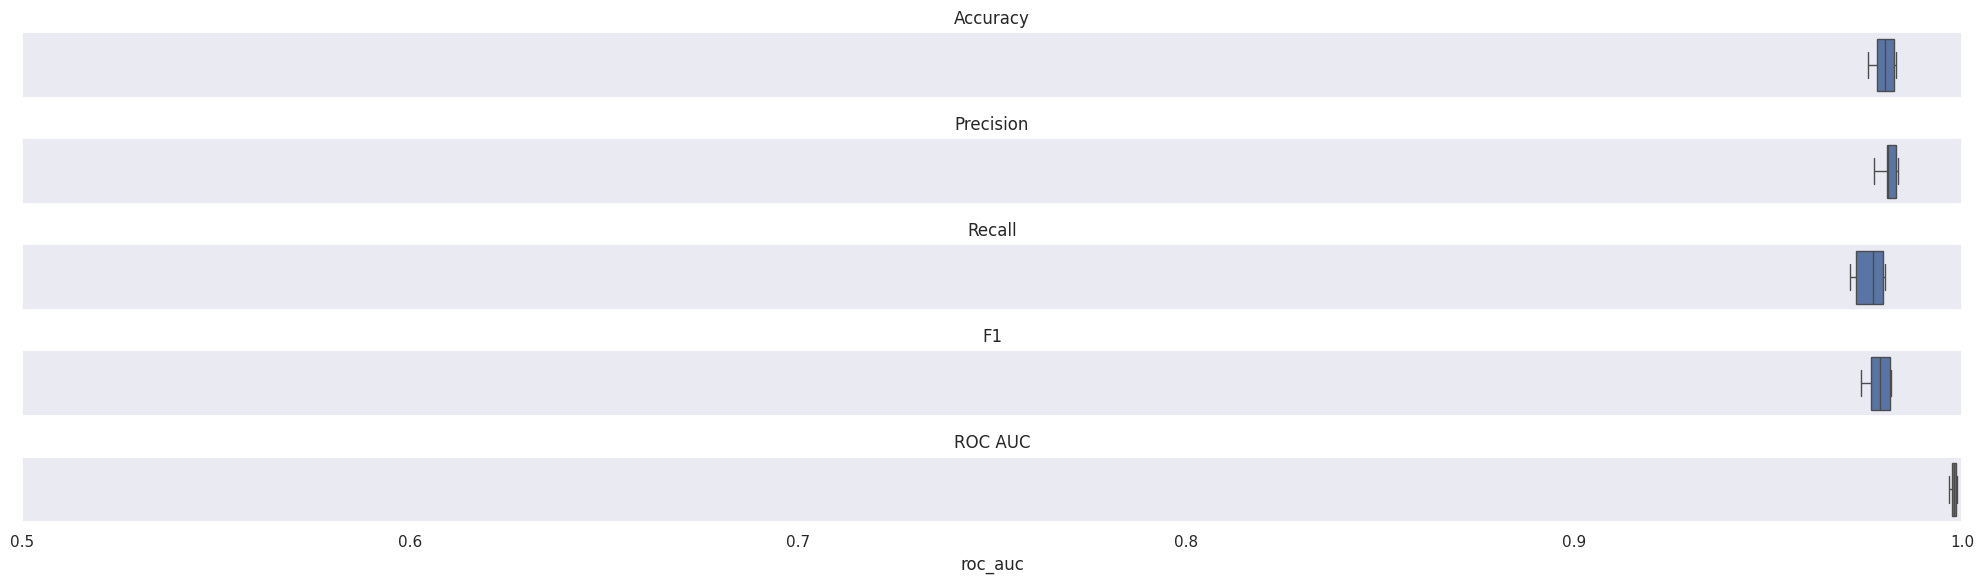

In [17]:
# Plot the spread of metrics across folds
fig, ax = plt.subplots(5, 1, figsize=(20, 6), sharex=True)

# Ax 1 - Accuracy
sns.boxplot(x='accuracy', data=model_metrics_kfolds_df, ax=ax[0])
ax[0].set_title('Accuracy')

# Ax 2 - Precision
sns.boxplot(x='precision', data=model_metrics_kfolds_df, ax=ax[1])
ax[1].set_title('Precision')

# Ax 3 - Recall
sns.boxplot(x='recall', data=model_metrics_kfolds_df, ax=ax[2])
ax[2].set_title('Recall')

# Ax 4 - F1
sns.boxplot(x='f1', data=model_metrics_kfolds_df, ax=ax[3])
ax[3].set_title('F1')

# Ax 5 - ROC AUC
sns.boxplot(x='roc_auc', data=model_metrics_kfolds_df, ax=ax[4])
ax[4].set_title('ROC AUC')

plt.xlim(0.5, 1.0)

plt.tight_layout()
fig.show()



In [18]:
model_metrics_kfold_tomd = model_metrics_kfolds_df.loc[:, ['fold', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
model_metrics_kfold_tomd_stat = model_metrics_kfold_tomd.agg(['mean', 'std'])
model_metrics_kfold_tomd_stat.drop(columns='fold', inplace=True)
model_metrics_kfold_tomd_stat.reset_index(names='fold', inplace=True)

# Get value from initial run
initial = model_metrics_df.loc[model_metrics_df['model'] == 'naive_bayes', ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
initial['fold'] = 'main run'

model_metrics_kfold_tomd = pd.concat([model_metrics_kfold_tomd, initial, model_metrics_kfold_tomd_stat])
model_metrics_kfold_tomd

md_table = model_metrics_kfold_tomd.to_markdown(tablefmt='github', index=False)

with open('analysis/model_metrics_kfolds.md', 'w') as f:
    f.write(md_table)
